In [1]:
#General imports
import numpy as np
from tqdm.notebook import tqdm

In [2]:
#Torch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as torchdata
import torch.optim as optim

/home/ivanoleksiyuk/WORK/jet_clip/.env/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
#Plotting
import matplotlib.pyplot as plt

In [4]:
#Local imports 
from encodermodels import SimpleConvNetEncoder
from datasets import DataManager
from clip_loss import CLIPLoss

In [5]:
#Fetching the device that will be used throughout this notebook
device = torch.device(
    "cpu") if not torch.cuda.is_available() else torch.device("cuda:0")
print("Using device", device)

Using device cuda:0



DEFINE DATA AND HYPERPARAMETERS

In [6]:
#Hyperparameters TODO: Move to config file
data_config = "QCD1f"
batch_size = 64 #256
latent_dims=10
epochs=10
lr=1e-4
transform1_name = "None"
transform2_name = "None"

In [7]:
#import preprocessing as pp

transform1 = None
transform2 = None 

# %%
# DEFINE A DATASET MANAGER
DM = DataManager(data_config=data_config, transform=None)

In [8]:
#Create data loaders 
train_loader = torchdata.DataLoader(
    DM.train_set, batch_size=batch_size, shuffle=True, drop_last=True)
val_loader = torchdata.DataLoader(
    DM.val_set, batch_size=batch_size, shuffle=False, num_workers=4, drop_last=True)
test_bg_loader = torchdata.DataLoader(
    DM.test_bg, batch_size=batch_size, shuffle=False, num_workers=4, drop_last=False)
test_sg_loader = torchdata.DataLoader(
    DM.test_sg, batch_size=batch_size, shuffle=False, num_workers=4, drop_last=False)

In [9]:
#Create model
class CLIPLikeModel(nn.Module):
    def __init__(self, latent_dims=10, transform1=None, transform2=None):
        super(CLIPLikeModel, self).__init__()
        self.encoder1 = SimpleConvNetEncoder(latent_dims=latent_dims)
        self.encoder2 = SimpleConvNetEncoder(latent_dims=latent_dims)
        self.clip_loss = CLIPLoss()
        self.transform1 = transform1
        self.transform2 = transform2
        
    def forward(self, x):
        if self.transform1 is not None:
            x1 = self.transform1(x)
        else:
            x1 = x
        if self.transform2 is not None:
            x2 = self.transform2(x)
        else:
            x2 = x
        z1 = self.encoder1(x1)
        z2 = self.encoder2(x2)
        loss = self.clip_loss(z1, z2)
        return loss

    def encode1(self, x):
        if self.transform1 is not None:
            x1 = self.transform1(x)
        else:
            x1 = x
        z1 = self.encoder1(x1)
        return z1

    def encode2(self, x):      
        if self.transform2 is not None:
            x2 = self.transform2(x)
        else:
            x2 = x
        z2 = self.encoder2(x2)
        return z2

    def training_step(self, batch):
        loss = self.forward(batch)
        self.log('train_loss', loss)
        return loss

    def validation_step(self, batch):
        loss = self.forward(batch)
        self.log('val_loss', loss)
        return loss
    
CLM=CLIPLikeModel(latent_dims, transform1, transform2).to(device)


In [10]:
optimizer = optim.Adam(CLM.parameters(), lr=lr)

[1,   200] loss: 3.854888
[1,   400] loss: 3.597598
[1,   600] loss: 3.585666
[1,   800] loss: 3.551520
[1,  1000] loss: 3.512057
[1,  1200] loss: 3.468028
[1,  1400] loss: 3.438543
3.4268032747965593
[2,   200] loss: 3.422618
[2,   400] loss: 3.421130
[2,   600] loss: 3.416167
[2,   800] loss: 3.403925
[2,  1000] loss: 3.399075
[2,  1200] loss: 3.384707
[2,  1400] loss: 3.382134
3.3760929703712463
[3,   200] loss: 3.373563
[3,   400] loss: 3.367129
[3,   600] loss: 3.370285
[3,   800] loss: 3.364928
[3,  1000] loss: 3.359689
[3,  1200] loss: 3.359207
[3,  1400] loss: 3.357213
3.3606539154664063
[4,   200] loss: 3.353297
[4,   400] loss: 3.350221
[4,   600] loss: 3.345684
[4,   800] loss: 3.344198
[4,  1000] loss: 3.340165
[4,  1200] loss: 3.334336
[4,  1400] loss: 3.333120
3.3290603382465167
[5,   200] loss: 3.328129
[5,   400] loss: 3.327075
[5,   600] loss: 3.325826
[5,   800] loss: 3.324262
[5,  1000] loss: 3.322090
[5,  1200] loss: 3.321832
[5,  1400] loss: 3.321390
3.324571091777

KeyboardInterrupt: 

In [ ]:
### TRAIN or load a MODEL if needed
from find_matching_files import find 
from pytorch_lightning import Trainer, ModelCheckpoint, LearningRateMonitor, EarlyStopping
import os
import time
import numpy as np

def train(CLM, exp_path, model_name="model", max_epochs=200, best_validation=True):
    """
        A function to train a model. If a pretrained model exists, it will be loaded and training will be skipped.
        case 1 - pretrained model exists and best_validation=True: load the pretrained model with the best validation result from first epoch to max_epochs
        case 2 - pretrained model exists and best_validation=False: load the pretrained model with the last epoch from first epoch to max_epochs
    """
    result = None
    # Check whether pretrained model exists. If yes, load it and skip training
    ckpt_files=find( model_name+"_e=????.ckpt", exp_path)
    ckpt_epochs=[int(ckpt_file[-9:-5]) for ckpt_file in ckpt_files]
    print(ckpt_epochs)
    ckpt_epochs_arr=np.array(ckpt_epochs)
    print("searching for:", os.path.join(exp_path, model_name+"_e={:04d}".format(max_epochs)+".ckpt"))
    if max_epochs in ckpt_epochs:
        pretrained_filename = os.path.join(exp_path, model_name+"_e={:04d}".format(max_epochs)+".ckpt")
        print("Found pretrained model, loading...")
        ckpt = torch.load(pretrained_filename)
        CLM.load_state_dict(ckpt['state_dict'])
        result = ckpt.get("result", None)
    elif np.any(ckpt_epochs_arr<max_epochs):
        print("found checkpoint. Continue training...")
        ckpt_epochs_arr-=max_epochs
        ckpt_epochs_arr[ckpt_epochs_arr>max_epochs]=-10000000
        arg=np.argmax(ckpt_epochs_arr)
        print(arg)
        pretrained_filename = os.path.join(exp_path, model_name+"_e={:04d}".format(ckpt_epochs[arg])+".ckpt")
        trainer = pl.Trainer(default_root_dir=os.path.join(exp_path, model_name), 
                             gpus=1 if torch.cuda.is_available() else 0, 
                             max_epochs=max_epochs+1, 
                             gradient_clip_val=1.0,
                             callbacks=[ModelCheckpoint(dirpath=exp_path, 
                                                        filename=model_name+"_e{epoch:04d}",
                                                        save_top_k=-1),
                                        ModelCheckpoint(dirpath=exp_path, 
                                                        filename=model_name+"_best{epoch:04d}",
                                                        monitor="val_bpd", mode="min"),
                                        LearningRateMonitor("epoch"),
                                        EarlyStopping(monitor="val_bpd", mode="min", patience=10)],
                             logger=loggers, 
                             log_every_n_steps=1,
                             resume_from_checkpoint=pretrained_filename)
        trainer.logger._log_graph = True
        trainer.logger._default_hp_metric = None # Optional logging argument that we don't need
        #train_data_loader = data.DataLoader(DM.train_set, batch_size=batch_size, shuffle=True, drop_last=True, pin_memory=True, num_workers=8)
        trainer.fit(CLM, train_data_loader, val_loader)
        
        val_result = trainer.test(CLM, val_loader, verbose=False)
        start_time = time.time()
        test_result = trainer.test(CLM, test_loader, verbose=False)
        duration = time.time() - start_time
        result = {"test": test_result, "val": val_result, "time": duration / len(test_loader) / CLM.import_samples}
    else:
        print("No checkpoint found. starting training...")
        trainer = pl.Trainer(default_root_dir=os.path.join(exp_path, model_name), 
                             gpus=1 if torch.cuda.is_available() else 0, 
                             max_epochs=max_epochs+1, 
                             gradient_clip_val=1.0,
                             callbacks=[ModelCheckpoint(dirpath=exp_path, 
                                                        filename=model_name+"_me{epoch:04d}",
                                                        save_top_k=-1),
                                        ModelCheckpoint(dirpath=exp_path, 
                                                        filename=model_name+"_best{epoch:04d}",
                                                        monitor="val_bpd", mode="min"),
                                        LearningRateMonitor("epoch"),
                                        EarlyStopping(monitor="val_bpd", mode="min", patience=10)],
                             logger=loggers,
                             log_every_n_steps=1)

        trainer.logger._log_graph = True
        trainer.logger._default_hp_metric = None # Optional logging argument that we don't need
        #train_data_loader = data.DataLoader(DM.train_set, batch_size=batch_size, shuffle=True, drop_last=True, pin_memory=True, num_workers=8)
        trainer.fit(CLM, train_data_loader, val_loader)
    
        val_result = trainer.test(CLM, val_loader, verbose=False)
        start_time = time.time()
        test_result = trainer.test(CLM, test_loader, verbose=False)
        duration = time.time() - start_time
        result = {"test": test_result, "val": val_result, "time": duration / len(test_loader) / flow.import_samples}
    
    return flow, result

MLC, result=train_flow(MLC, exp_path="models/" max_epochs=max_epochs)
#train_flow(flow, max_epochs=max_epochs)

In [12]:
data = next(iter(train_loader))
data[0]=data[0][:10]
inputs = data[0].reshape(
            data[0].shape[0], data[0].shape[3], data[0].shape[1], data[0].shape[2]).float()
inputs = inputs.to(device)
with torch.no_grad():
	embedding1 = CLM.encoder1.forward(inputs)
	embedding2 = CLM.encoder2.forward(inputs)

In [13]:
if latent_dims==2:
	plt.scatter([0], [0], c="black")
	xy=embedding1.cpu().detach().numpy()
	plt.scatter(xy[:, 0], xy[:, 1], c=np.arange(len(xy[:, 0])), cmap='turbo')
	xy=embedding2.cpu().detach().numpy()
	plt.scatter(xy[:, 0], xy[:, 1], c=np.arange(len(xy[:, 0])), cmap='turbo')

<AxesSubplot: >

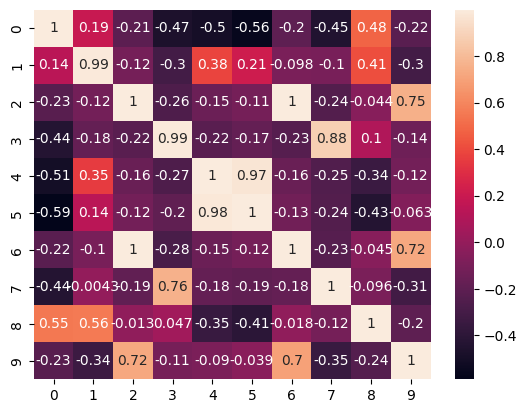

In [14]:
logits_1 = embedding1 @ embedding2.T
logits_2 = embedding2 @ embedding1.T
import seaborn as sns

sns.heatmap(logits_1.cpu().detach().numpy(), annot=True)


<AxesSubplot: >

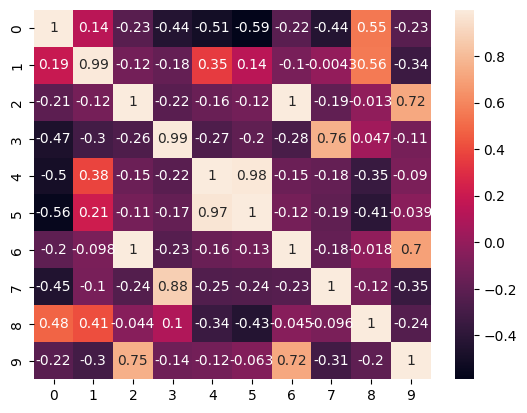

In [15]:
sns.heatmap(logits_2.cpu().detach().numpy(), annot=True)

In [16]:
num_logits = logits_1.shape[0]
labels = torch.arange(num_logits, device=device, dtype=torch.long)
print(labels)
print(F.cross_entropy(logits_1, labels))
print(F.cross_entropy(logits_2, labels))
loss = 0.5 * (
	F.cross_entropy(logits_1, labels) +
	F.cross_entropy(logits_2, labels)
)

tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], device='cuda:0')
tensor(1.5022, device='cuda:0')
tensor(1.5017, device='cuda:0')


In [17]:
def evaluate_cossim_from_loader(data_loader, CLM, iterations_max=None):
    scores = []
    for i, data in enumerate(data_loader):
        inputs = data[0].reshape(
            data[0].shape[0], data[0].shape[3], data[0].shape[1], data[0].shape[2]).float()
        inputs = inputs.to(device)

        #forward + backward + optimize
        with torch.no_grad():
            embedding1 = CLM.encode1(inputs)
            embedding2 = CLM.encode2(inputs)
            similarity = torch.diagonal(embedding1 @ embedding2.T)
        scores.append(similarity)
        if not (iterations_max is None):
            if i>=iterations_max:
                break
    scores=torch.concat(scores)
    scores=1-scores.cpu().detach().numpy()
    return scores

bg_ev_sc=evaluate_cossim_from_loader(test_bg_loader, CLM)
sg_ev_sc=evaluate_cossim_from_loader(test_sg_loader, CLM)

AttributeError: 'CLIPLikeModel' object has no attribute 'encode1'

(array([2.0127e+04, 8.2270e+03, 3.7510e+03, 2.2600e+03, 1.5000e+03,
        9.4000e+02, 6.7700e+02, 5.4000e+02, 4.2000e+02, 2.8300e+02,
        2.5600e+02, 2.0600e+02, 1.4800e+02, 1.2200e+02, 1.0500e+02,
        8.4000e+01, 4.8000e+01, 4.9000e+01, 3.8000e+01, 2.9000e+01,
        3.6000e+01, 2.4000e+01, 2.4000e+01, 1.8000e+01, 9.0000e+00,
        1.0000e+01, 9.0000e+00, 1.1000e+01, 3.0000e+00, 8.0000e+00,
        8.0000e+00, 3.0000e+00, 5.0000e+00, 2.0000e+00, 4.0000e+00,
        2.0000e+00, 1.0000e+00, 2.0000e+00, 0.0000e+00, 1.0000e+00,
        3.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00]),
 array([0.        , 0.00204082, 0.00408163, 0.00612245, 0.00816327,
        0.01020408, 0.0122449 , 0.01428571, 0.01632653, 0.01836735,
        0.02040816, 0.02244898, 0.0244898 , 0.02653061, 0.02857143,
        0.03061224, 0.03265306, 0.03469388, 0.03673469, 0.03877551,
        0.04081633, 0.04285714, 0.04489796, 0.04693878, 0.

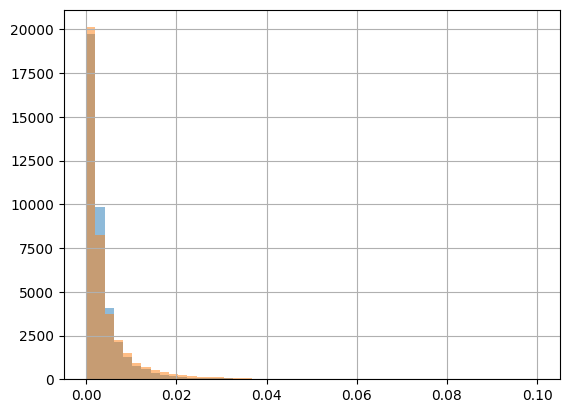

In [ ]:
plt.figure()
plt.grid()
plt.hist(bg_ev_sc, bins=np.linspace(0, 0.1, 50), alpha=0.5, label="background")
plt.hist(sg_ev_sc, bins=np.linspace(0, 0.1, 50), alpha=0.5, label="signal")

/tmp/ipykernel_1427/1849933761.py:7: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr, 1/fpr)
/tmp/ipykernel_1427/1849933761.py:9: RuntimeWarning: divide by zero encountered in divide
  plt.plot(np.linspace(0, 1, 1000), 1/np.linspace(0, 1, 1000), color="gray")
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


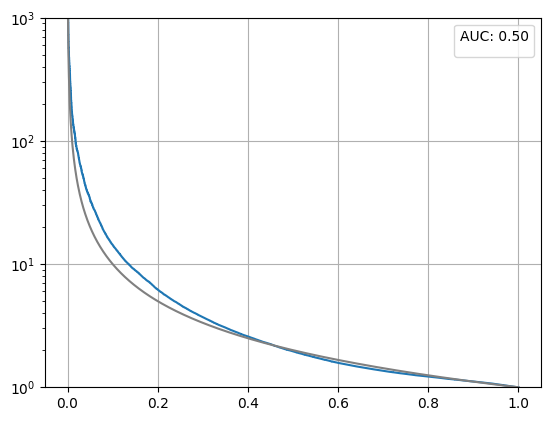

In [ ]:
from sklearn.metrics import roc_auc_score, roc_curve
labels=np.concatenate((np.zeros(len(bg_ev_sc)), np.ones(len(sg_ev_sc))))
auc = roc_auc_score(labels, np.append(bg_ev_sc, sg_ev_sc))
fpr , tpr , thresholds = roc_curve(labels, np.append(bg_ev_sc, sg_ev_sc))
plt.figure()
plt.grid()
plt.plot(tpr, 1/fpr)
plt.ylim(ymin=1, ymax=1000)
plt.plot(np.linspace(0, 1, 1000), 1/np.linspace(0, 1, 1000), color="gray")
plt.yscale("log")
plt.legend(title=f'AUC: {auc:.2f}')
#plt.savefig(eval_path+"/ROC.png")

In [ ]:
def evaluate_embedding_from_loader(data_loader, encoder, iterations_max=None):
    ems = []
    for i, data in enumerate(data_loader):
        inputs = data[0].reshape(
            data[0].shape[0], data[0].shape[3], data[0].shape[1], data[0].shape[2]).float()
        inputs = inputs.to(device)

        #forward + backward + optimize
        with torch.no_grad():
            embedding = encoder(inputs)
        if not (iterations_max is None):
            if i>=iterations_max:
                break
        ems.append(embedding)
    ems=torch.concat(ems)
    ems=ems.cpu().detach().numpy()
    return ems

bg_em=evaluate_embedding_from_loader(test_bg_loader, CLM.encoder1, iterations_max=5)
sg_em=evaluate_embedding_from_loader(test_sg_loader, CLM.encoder1, iterations_max=5)
all_em=np.concatenate([bg_em, sg_em])
lbl=np.concatenate([np.zeros(len(bg_em), dtype=np.bool), np.ones(len(sg_em), dtype=np.bool)])

/tmp/ipykernel_1427/810101881.py:22: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  lbl=np.concatenate([np.zeros(len(bg_em), dtype=np.bool), np.ones(len(sg_em), dtype=np.bool)])


In [ ]:
from sklearn.manifold import TSNE
Tembeded=TSNE().fit_transform(all_em)

/home/ivanoleksiyuk/WORK/jet_clip/.env/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/ivanoleksiyuk/WORK/jet_clip/.env/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


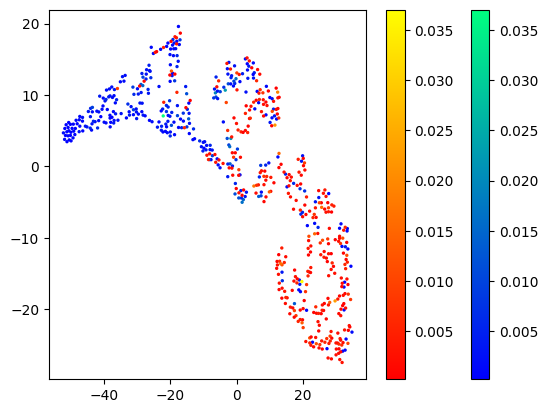

In [ ]:
plt.figure(dpi=100)
plt.scatter(Tembeded[True^lbl][:, 0], Tembeded[True^lbl][:, 1], c=bg_ev_sc[:len(Tembeded[True^lbl][:, 0])], cmap="winter", s=2)
plt.colorbar()
plt.scatter(Tembeded[lbl][:, 0], Tembeded[lbl][:, 1], c=bg_ev_sc[:len(Tembeded[lbl][:, 0])], cmap="autumn", s=2)
plt.colorbar()

In [39]:
len(all_em)

640

In [ ]:
### TRAIN or load a MODEL if needed
from find_matching_files import find 


def train(encoder1, encoder2, exp_path, model_name="model", max_epochs=200, best_validation=True):
    """
        A function to train a model. If a pretrained model exists, it will be loaded and training will be skipped.
        case 1 - pretrained model exists and best_validation=True: load the pretrained model with the best validation result from first epoch to max_epochs
        case 2 - pretrained model exists and best_validation=False: load the pretrained model with the last epoch from first epoch to max_epochs
    """
    result = None
    # Check whether pretrained model exists. If yes, load it and skip training
    ckpt_files=find( model_name+"_e=????.ckpt", exp_path)
    ckpt_epochs=[int(ckpt_file[-9:-5]) for ckpt_file in ckpt_files]
    print(ckpt_epochs)
    ckpt_epochs_arr=np.array(ckpt_epochs)
    print("searching for:", os.path.join(exp_path, model_name+"_e={:04d}".format(max_epochs)+".ckpt"))
    if max_epochs in ckpt_epochs:
        pretrained_filename = os.path.join(exp_path, model_name+"_e={:04d}".format(max_epochs)+".ckpt")
        print("Found pretrained model, loading...")
        ckpt = torch.load(pretrained_filename)
        flow.load_state_dict(ckpt['state_dict'])
        result = ckpt.get("result", None)
    elif np.any(ckpt_epochs_arr<max_epochs):
        print("found checkpoint. Continue training...")
        ckpt_epochs_arr-=max_epochs
        ckpt_epochs_arr[ckpt_epochs_arr>max_epochs]=-10000000
        arg=np.argmax(ckpt_epochs_arr)
        print(arg)
        pretrained_filename = os.path.join(exp_path, model_name+"_e={:04d}".format(ckpt_epochs[arg])+".ckpt")
        trainer = pl.Trainer(default_root_dir=os.path.join(exp_path, model_name), 
                             gpus=1 if torch.cuda.is_available() else 0, 
                             max_epochs=max_epochs+1, 
                             gradient_clip_val=1.0,
                             callbacks=[ModelCheckpoint(dirpath=exp_path, 
                                                        filename=model_name+"_e{epoch:04d}",
                                                        save_top_k=-1),
                                        ModelCheckpoint(dirpath=exp_path, 
                                                        filename=model_name+"_best{epoch:04d}",
                                                        monitor="val_bpd", mode="min"),
                                        LearningRateMonitor("epoch"),
                                        EarlyStopping(monitor="val_bpd", mode="min", patience=10)],
                             logger=loggers, 
                             log_every_n_steps=1,
                             resume_from_checkpoint=pretrained_filename)
        trainer.logger._log_graph = True
        trainer.logger._default_hp_metric = None # Optional logging argument that we don't need
        train_data_loader = data.DataLoader(DM.train_set, batch_size=batch_size, shuffle=True, drop_last=True, pin_memory=True, num_workers=8)
        trainer.fit(model, train_data_loader, val_loader)
        
        val_result = trainer.test(model, val_loader, verbose=False)
        start_time = time.time()
        test_result = trainer.test(model, test_loader, verbose=False)
        duration = time.time() - start_time
        result = {"test": test_result, "val": val_result, "time": duration / len(test_loader) / flow.import_samples}
    else:
        print("No checkpoint found. starting training...")
        trainer = pl.Trainer(default_root_dir=os.path.join(exp_path, model_name), 
                             gpus=1 if torch.cuda.is_available() else 0, 
                             max_epochs=max_epochs+1, 
                             gradient_clip_val=1.0,
                             callbacks=[ModelCheckpoint(dirpath=exp_path, 
                                                        filename=model_name+"_me{epoch:04d}",
                                                        save_top_k=-1),
                                        ModelCheckpoint(dirpath=exp_path, 
                                                        filename=model_name+"_best{epoch:04d}",
                                                        monitor="val_bpd", mode="min"),
                                        LearningRateMonitor("epoch"),
                                        EarlyStopping(monitor="val_bpd", mode="min", patience=10)],
                             logger=loggers,
                             log_every_n_steps=1)

        trainer.logger._log_graph = True
        trainer.logger._default_hp_metric = None # Optional logging argument that we don't need
        train_data_loader = data.DataLoader(DM.train_set, batch_size=batch_size, shuffle=True, drop_last=True, pin_memory=True, num_workers=8)
        trainer.fit(flow, train_data_loader, val_loader)
    
        val_result = trainer.test(flow, val_loader, verbose=False)
        start_time = time.time()
        test_result = trainer.test(flow, test_loader, verbose=False)
        duration = time.time() - start_time
        result = {"test": test_result, "val": val_result, "time": duration / len(test_loader) / flow.import_samples}
    
    return flow, result

flow, result=train_flow(flow, max_epochs=max_epochs)
#train_flow(flow, max_epochs=max_epochs)

In [ ]:
def trainer(model, optimizer, train_loader, epochs):
    for epoch in range(epochs):  # loop over the dataset multiple times
        running_loss = 0.0
        for i, data in enumerate(train_loader):
            inputs = data[0].reshape(
                data[0].shape[0], data[0].shape[3], data[0].shape[1], data[0].shape[2]).float()
            inputs = inputs.to(device)
            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            loss = model.forward(inputs)
            loss.backward()
            optimizer.step()

            # print statistics
            running_loss += model.clip_loss.item()
            print_T = 200
            if i % print_T == print_T-1:    # print every 2000 mini-batches
                print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / print_T:.6f}')
                running_loss = 0.0
        
        #Validation once per epoch 
        valid_loss = 0.0
        for i, data in enumerate(val_loader):
            inputs = data[0].reshape(
                data[0].shape[0], data[0].shape[3], data[0].shape[1], data[0].shape[2]).float()
            inputs = inputs.to(device)

            # forward + backward + optimize
            with torch.no_grad():
                loss = model.forward(inputs)

            # print statistics
            valid_loss += model.clip_loss.item()
        print(valid_loss/i)
    
trainer(CLM, optimizer, train_loader, epochs)